# Imports

In [ ]:
from google.colab import drive
import os
import pandas as pd
import torch

from torch.utils.data import Dataset

from torch import nn
from transformers import AutoModelForSequenceClassification, AutoTokenizer

import time
from tqdm import tqdm
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

from torch.utils.data import DataLoader
from transformers import get_linear_schedule_with_warmup
from transformers.optimization import AdamW
from sys import platform
import csv
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
! pip3 install transformers

# Google Drive


In [ ]:
drive.mount('/content/drive', force_remount=True)

DATA_PATH = '/content/drive/My Drive/binary_sentiment_classification/data/'
MODELS_PATH = '/content/drive/My Drive/binary_sentiment_classification/models/'

if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH)  # Put data manually into this folder in order to use this notebook
if not os.path.exists(MODELS_PATH):
    os.makedirs(MODELS_PATH)

Mounted at /content/drive


# Data

In [ ]:
train_dataframe = pd.read_csv(os.path.join(DATA_PATH,'train.tsv'),sep='\t',header=None, names=['labels','sentences'])
print(f'TRAIN:\n\n{train_dataframe.head(10)}\n\n')

validation_dataframe = pd.read_csv(os.path.join(DATA_PATH,'validation.tsv'),sep='\t',header=None, names=['labels','sentences'])
print(f'VALIDATION:\n\n{validation_dataframe.head(10)}\n\n')

test_dataframe = pd.read_csv(os.path.join(DATA_PATH,'test.tsv'),sep='\t',header=None, names=['labels','sentences'])
print(f'TEST:\n\n{test_dataframe.head(10)}\n\n')

TRAIN:

   labels                                          sentences
0       1  a stirring , funny and finally transporting re...
1       0  apparently reassembled from the cutting-room f...
2       0  they presume their audience wo n't sit still f...
3       1  this is a visually stunning rumination on love...
4       1  jonathan parker 's bartleby should have been t...
5       1  campanella gets the tone just right -- funny i...
6       0  a fan film that for the uninitiated plays bett...
7       1  béart and berling are both superb , while hupp...
8       0  a little less extreme than in the past , with ...
9       0                     the film is strictly routine .


VALIDATION:

   labels                                          sentences
0       0                       one long string of cliches .
1       0  if you 've ever entertained the notion of doin...
2       0  k-19 exploits our substantial collective fear ...
3       0  it 's played in the most straight-faced fashio...
4

## Data Analysis

## Data Processing


In [ ]:
class DatasetProcessor(Dataset):

    def __init__(
        self,
        tokenizer,
        dataframe,
        max_sequence_length: int = 50
    ):
        super(DatasetProcessor, self).__init__()
        self.tokenizer = tokenizer
        self.max_sequence_length = max_sequence_length
        self.input_ids, self.attention_mask, self.token_type_ids, self.labels = self.to_tensor(dataframe)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.attention_mask[idx], self.token_type_ids[idx], self.labels[idx]

    def to_tensor(self, dataframe):
        sentences = dataframe['sentences'].values
        labels = dataframe['labels'].values

        tokens_seq = list(map(self.tokenizer.tokenize, sentences))
        result = list(map(self.truncate_and_pad, tokens_seq))

        input_ids = [i[0] for i in result]
        attention_mask = [i[1] for i in result]
        token_type_ids = [i[2] for i in result]

        return (
               torch.Tensor(input_ids).type(torch.long),
               torch.Tensor(attention_mask).type(torch.long),
               torch.Tensor(token_type_ids).type(torch.long),
               torch.Tensor(labels).type(torch.long)
               )


    def truncate_and_pad(self, tokens_seq):
        tokens_seq = ['[CLS]'] + tokens_seq
        if len(tokens_seq) > self.max_sequence_length:
            tokens_seq = tokens_seq[0 : self.max_sequence_length]
        padding = [0] * (self.max_sequence_length - len(tokens_seq))
        input_ids = self.tokenizer.convert_tokens_to_ids(tokens_seq)
        input_ids += padding
        attention_mask = [1] * len(tokens_seq) + padding
        token_type_ids = [0] * (self.max_sequence_length)

        assert len(input_ids) == self.max_sequence_length
        assert len(attention_mask) == self.max_sequence_length
        assert len(token_type_ids) == self.max_sequence_length

        return input_ids, attention_mask, token_type_ids


# Model

In [ ]:
class TransformerBinarySequenceClassificator(nn.Module):
    def __init__(self, model_name: str, requires_grad: bool = True) -> None:
        super(TransformerBinarySequenceClassificator, self).__init__()
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=True)
        self.requires_grad = requires_grad
        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

        for parameter in self.model.parameters():
            parameter.requires_grad = requires_grad

    def forward(self, batch_seqs, batch_seq_masks, batch_seq_segments, labels=None):
        if labels is not None:
            outputs = self.model(
                input_ids=batch_seqs,
                attention_mask=batch_seq_masks,
                token_type_ids=batch_seq_segments,
                labels=labels
            )
            loss, logits = outputs.loss, outputs.logits
        else:
            outputs = self.model(
                input_ids=batch_seqs,
                attention_mask=batch_seq_masks,
                token_type_ids=batch_seq_segments
            )
            loss = None
            logits = outputs.logits
        probabilities = nn.functional.softmax(logits, dim=-1)
        return loss, logits, probabilities

# Helper functions


In [ ]:
def classification_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    return accuracy, precision, recall, f1

In [ ]:
def correct_predictions(output_probabilities, targets):
    _, out_classes = output_probabilities.max(dim=1)
    correct = (out_classes == targets).sum()
    return correct.item()

# Training, validation and testing functions

In [ ]:
def train(model, dataloader, optimizer, epoch_number, max_gradient_norm):
    model.train()
    device = model.device
    epoch_start = time.time()
    batch_time_avg = 0.0
    running_loss = 0.0
    correct_preds = 0
    tqdm_batch_iterator = tqdm(dataloader)
    for batch_index, (batch_seqs, batch_seq_masks, batch_seq_segments, batch_labels) in enumerate(tqdm_batch_iterator):
        batch_start = time.time()
        seqs, masks, segments, labels = batch_seqs.to(device), batch_seq_masks.to(device), batch_seq_segments.to(device), batch_labels.to(device)
        optimizer.zero_grad()
        loss, logits, probabilities = model(seqs, masks, segments, labels)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_gradient_norm)
        optimizer.step()
        batch_time_avg += time.time() - batch_start
        running_loss += loss.item()
        correct_preds += correct_predictions(probabilities, labels)
        description = f'\t\tAverage batch time - {batch_time_avg/(batch_index+1):.4f}s\t\tRunning loss - {running_loss/(batch_index+1):.4f}\t\t'
        tqdm_batch_iterator.set_description(description)
    epoch_time = time.time() - epoch_start
    epoch_loss = running_loss / len(dataloader)
    epoch_accuracy = correct_preds / len(dataloader.dataset)
    return epoch_time, epoch_loss, epoch_accuracy

In [ ]:
def validate(model, dataloader):
    model.eval()
    device = model.device
    epoch_start = time.time()
    running_loss = 0.0
    running_accuracy = 0.0
    all_probabilities = []
    all_labels = []
    with torch.no_grad():
        for (batch_seqs, batch_seq_masks, batch_seq_segments, batch_labels) in dataloader:
            seqs = batch_seqs.to(device)
            masks = batch_seq_masks.to(device)
            segments = batch_seq_segments.to(device)
            labels = batch_labels.to(device)
            loss, logits, probabilities = model(seqs, masks, segments, labels)
            running_loss += loss.item()
            running_accuracy += correct_predictions(probabilities, labels)
            all_probabilities.extend(probabilities[:,1].cpu().numpy())
            all_labels.extend(batch_labels)
    epoch_time = time.time() - epoch_start
    epoch_loss = running_loss / len(dataloader)
    epoch_accuracy = running_accuracy / (len(dataloader.dataset))
    return epoch_time, epoch_loss, epoch_accuracy, roc_auc_score(all_labels, all_probabilities), all_probabilities

In [ ]:
def test(model, dataloader):
    model.eval()
    device = model.device
    time_start = time.time()
    batch_time = 0.0
    accuracy = 0.0
    all_probabilities = []
    all_labels = []
    with torch.no_grad():
        for (batch_seqs, batch_seq_masks, batch_seq_segments, batch_labels) in dataloader:
            batch_start = time.time()
            seqs, masks, segments, labels = batch_seqs.to(device), batch_seq_masks.to(device), batch_seq_segments.to(device), batch_labels.to(device)
            _, _, probabilities = model(seqs, masks, segments, labels)
            accuracy += correct_predictions(probabilities, labels)
            batch_time += time.time() - batch_start
            all_probabilities.extend(probabilities[:,1].cpu().numpy())
            all_labels.extend(batch_labels)
    batch_time /= len(dataloader)
    total_time = time.time() - time_start
    accuracy /= (len(dataloader.dataset))

    return batch_time, total_time, accuracy, all_probabilities

# Finetuning process

In [ ]:
def finetune_model(
        train_dataframe, validation_dataframe, test_dataframe,
        model_name: str,
        max_sequence_length: int = 50,
        epochs: int = 10,
        batch_size: int = 32,
        lr=2e-05,
        patience: int = 1,
        max_grad_norm: float = 10.0
    ):
    model = TransformerBinarySequenceClassificator(model_name=model_name, requires_grad = True)
    tokenizer = model.tokenizer

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    save_path = os.path.join(MODELS_PATH, model_name)
    if not os.path.exists(save_path):
        os.makedirs(save_path)


    train_data = DatasetProcessor(tokenizer, train_dataframe, max_sequence_length = max_sequence_length)
    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

    validation_data = DatasetProcessor(tokenizer, validation_dataframe, max_sequence_length = max_sequence_length)
    validation_loader = DataLoader(validation_data, shuffle=True, batch_size=batch_size)

    test_data = DatasetProcessor(tokenizer, test_dataframe, max_sequence_length = max_sequence_length)
    test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)


    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {
            'params':[p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
            'weight_decay':0.01
        },
        {
            'params':[p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
            'weight_decay':0.0
        }
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=lr)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.85, patience=0)

    best_accuracy = 0.0
    start_epoch = 1

    print('\n\nBEGIN FINETUNING PROCESS\n')
    print('\tINFO:')
    print(f'\t\tModel     - {model_name.upper()}\n\t\tDevice    - {str(device).upper()}\n')

    print('\tINITIAL VALIDATION:')
    init_validation_time, init_validation_loss, init_validation_accuracy, init_validation_auc, _, = validate(model, validation_loader)
    print(f'\t\tTime      : {init_validation_time:.4f}s\n\t\tLoss      : {init_validation_loss:.4f}')
    print(f'\t\tAccuracy  : {(init_validation_accuracy):.4%}\n\t\tAUC       : {init_validation_auc:.4f}\n\n')

    patience_counter = 0
    for epoch in range(start_epoch, epochs + 1):
        print(f'EPOCH {epoch}:\n')

        print('\tTRAINING:')
        epoch_time, epoch_loss, epoch_accuracy = train(model, train_loader, optimizer, epoch, max_grad_norm)
        print(f'\t\tTime      : {epoch_time:.4f}s\n\t\tLoss      : {epoch_loss:.4f}\n\t\tAccuracy  : {(epoch_accuracy):.4%}\n')

        print('\tVALIDATION:')
        epoch_time, epoch_loss, epoch_accuracy , epoch_auc, _, = validate(model, validation_loader)
        print(f'\t\tTime      : {epoch_time:.4f}s\n\t\tLoss      : {epoch_loss:.4f}')
        print(f'\t\tAccuracy  : {(epoch_accuracy):.4%}\n\t\tROC-AUC   : {epoch_auc:.4f}\n')

        scheduler.step(epoch_accuracy)

        if epoch_accuracy < best_accuracy:
            patience_counter += 1
        else:
            best_accuracy = epoch_accuracy
            patience_counter = 0

            print('\tTESTING:')
            test_time, test_loss, _, test_auc, all_probabilities = validate(model, test_loader)
            print(f'\t\tTime      : {test_time:.4f}s\n\t\tLoss      : {test_loss:.4f}')

            test_predictions = pd.DataFrame({'probability_1':all_probabilities})
            test_predictions['probability_0'] = 1 - test_predictions['probability_1']
            test_predictions['prediction'] = test_predictions.apply(
                lambda x: 0 if (x['probability_0'] > x['probability_1']) else 1,
                axis=1
            )
            test_predictions = test_predictions[['probability_0', 'probability_1', 'prediction']]

            test_accuracy, test_precision, test_recall, test_f1 = classification_metrics(test_dataframe['labels'], test_predictions['prediction'])
            print(f'\t\tAccuracy  : {test_accuracy:.4%}\n\t\tPrecision : {test_precision:.4%}\n\t\tRecall    : {test_recall:.4%}\n\t\tF1        : {test_f1:.4f}\n\t\tROC-AUC   : {test_auc:.4f}\n\n')

            model_file_path = os.path.join(save_path, 'model.pt')
            torch.save(
                model.state_dict(),
                model_file_path
            )

            metrics_file_path = os.path.join(save_path, 'metrics.tsv')
            with open(metrics_file_path, 'w', newline='') as file:
                writer = csv.writer(file, delimiter='\t')
                writer.writerow(['Loss', test_loss])
                writer.writerow(['Accuracy', test_accuracy])
                writer.writerow(['Precision', test_precision])
                writer.writerow(['Recall', test_recall])
                writer.writerow(['F1', test_f1])
                writer.writerow(['ROC-AUC', test_auc])

            roc_curve_path = os.path.join(save_path, 'roc_curve.png')
            fpr, tpr, _ = roc_curve(test_dataframe['labels'], all_probabilities)
            plt.figure(figsize=(5.5, 5.5))
            plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve area = %0.2f' % test_auc)
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.0])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic Curve')
            plt.legend(loc='lower right')
            plt.savefig(roc_curve_path)
            plt.show()
            plt.close()

            confusion_matrix_path = os.path.join(save_path, 'confusion_matrix.png')
            conf_matrix = confusion_matrix(test_dataframe['labels'], test_predictions['prediction'])
            fig, ax = plt.subplots(figsize=(6, 6))
            disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
            disp.plot(ax=ax, cmap=plt.cm.Blues)
            plt.title('Confusion Matrix')
            plt.savefig(confusion_matrix_path)
            plt.show()
            plt.close()

            print(f'\n\n\tModel saved to {model_file_path}')
            print(f'\tMetrics saved to {metrics_file_path}')
            print(f'\tROC curve saved to {roc_curve_path}')
            print(f'\tConfusion matrix saved to {confusion_matrix_path}\n\n')


        if patience_counter >= patience:
            print('\tEARLY STOPPING:')
            print('\t\tValidation accuracy not improving...\n\n')
            break

# Actual training and finetuning

In [ ]:
PRETRAINED_MODELS = {
  'bert-base-uncased': '12-layer, 768-hidden, 12-heads, 110M parameters. Trained on lower-cased English text.',
  'bert-large-uncased': '24-layer, 1024-hidden, 16-heads, 340M parameters. Trained on lower-cased English text.',
  'bert-base-cased': '12-layer, 768-hidden, 12-heads, 110M parameters. Trained on cased English text.',
  'bert-large-cased': '24-layer, 1024-hidden, 16-heads, 340M parameters. Trained on cased English text.',

  'albert-base-v1': '12 repeating layers, 128 embedding, 768-hidden, 12-heads, 11M parameters. ALBERT base model.',
  'albert-large-v1': '24 repeating layers, 128 embedding, 1024-hidden, 16-heads, 17M parameters. ALBERT large model.',####
  'albert-xlarge-v1': '24 repeating layers, 128 embedding, 2048-hidden, 16-heads, 58M parameters. ALBERT xlarge model.',
  'albert-xxlarge-v1': '12 repeating layer, 128 embedding, 4096-hidden, 64-heads, 223M parameters. ALBERT xxlarge model.',
  'albert-base-v2': '12 repeating layers, 128 embedding, 768-hidden, 12-heads, 11M parameters. ALBERT base model with no dropout, additional training data and longer training.',
  'albert-large-v2': '24 repeating layers, 128 embedding, 1024-hidden, 16-heads, 17M parameters. ALBERT large model with no dropout, additional training data and longer training.',####
  'albert-xlarge-v2': '24 repeating layers, 128 embedding, 2048-hidden, 16-heads, 58M parameters. ALBERT xlarge model with no dropout, additional training data and longer training.',
  'albert-xxlarge-v2': '12 repeating layer, 128 embedding, 4096-hidden, 64-heads, 223M parameters. ALBERT xxlarge model with no dropout, additional training data and longer training.',

  'roberta-base': '12-layer, 768-hidden, 12-heads, 125M parameters. RoBERTa using the BERT-base architecture.',
  'roberta-large': '24-layer, 1024-hidden, 16-heads, 355M parameters. RoBERTa using the BERT-large architecture.',
  'distilroberta-base': '6-layer, 768-hidden, 12-heads, 82M parameters. The DistilRoBERTa model distilled from the RoBERTa model roberta-base checkpoint.',

  'camembert-base': '12-layer, 768-hidden, 12-heads, 110M parameters. CamemBERT using the BERT-base architecture.',

  'xlm-roberta-base': '12-layers, 768-hidden-state, 3072 feed-forward hidden-state, 8-heads, 125M parameters. Trained on on 2.5 TB of newly created clean CommonCrawl data in 100 languages.',
  'xlm-roberta-large': '24-layers, 1027-hidden-state, 4096 feed-forward hidden-state, 16-heads, 355M parameters. Trained on 2.5 TB of newly created clean CommonCrawl data in 100 languages.',

  'xlnet-base-cased': '12-layer, 768-hidden, 12-heads, 110M parameters. XLNet English model.',
  'xlnet-large-cased': '24-layer, 1024-hidden, 16-heads, 340M parameters. XLNet Large English model.'
}

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/710 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/893M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-xxlarge-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(




BEGIN FINETUNING PROCESS

	INFO:
		Model     - ALBERT-XXLARGE-V2
		Device    - CUDA

	INITIAL VALIDATION:
		Time      : 66.5565s
		Loss      : 0.9121
		Accuracy  : 53.2110%
		AUC       : 0.5337


EPOCH 1:

	TRAINING:


		Average batch time - 3.2208s		Running loss - 0.4191		: 100%|██████████| 217/217 [24:23<00:00,  6.75s/it]


		Time      : 1463.7881s
		Loss      : 0.4191
		Accuracy  : 81.0549%

	VALIDATION:
		Time      : 72.5360s
		Loss      : 0.2771
		Accuracy  : 90.3670%
		ROC-AUC   : 0.9638

	TESTING:
		Time      : 151.0496s
		Loss      : 0.2229
		Accuracy  : 92.3668%
		Precision : 90.8705%
		Recall    : 94.1694%
		F1        : 0.9249
		ROC-AUC   : 0.9784




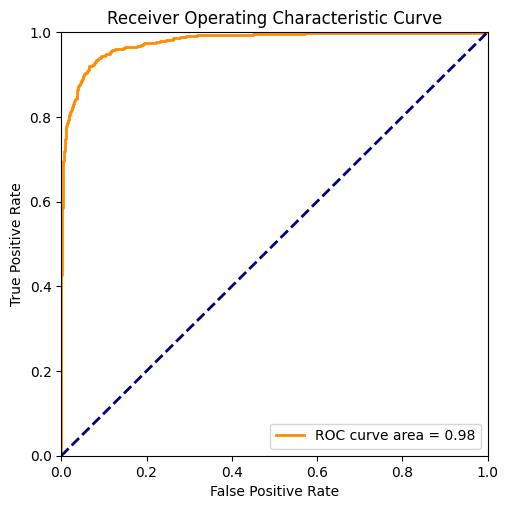

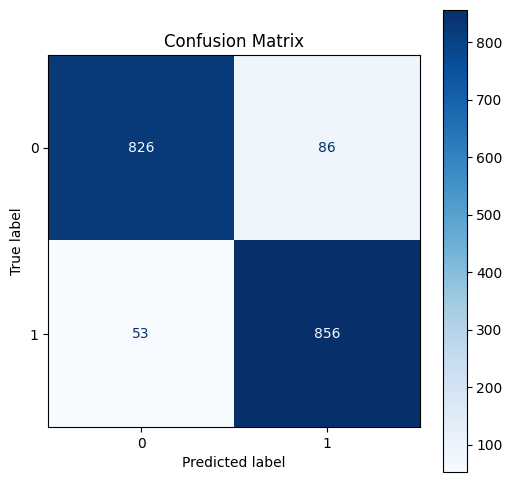



	Model saved to /content/drive/My Drive/binary_sentiment_classification/models/albert-xxlarge-v2/model.pt
	Metrics saved to /content/drive/My Drive/binary_sentiment_classification/models/albert-xxlarge-v2/metrics.tsv
	ROC curve saved to /content/drive/My Drive/binary_sentiment_classification/models/albert-xxlarge-v2/roc_curve.png
	Confusion matrix saved to /content/drive/My Drive/binary_sentiment_classification/models/albert-xxlarge-v2/confusion_matrix.png


EPOCH 2:

	TRAINING:


		Average batch time - 3.1835s		Running loss - 0.3631		: 100%|██████████| 217/217 [24:18<00:00,  6.72s/it]


		Time      : 1458.0714s
		Loss      : 0.3631
		Accuracy  : 88.2948%

	VALIDATION:
		Time      : 72.6361s
		Loss      : 0.3102
		Accuracy  : 89.3349%
		ROC-AUC   : 0.9456

	EARLY STOPPING:
		Validation accuracy not improving...




config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(




BEGIN FINETUNING PROCESS

	INFO:
		Model     - ROBERTA-BASE
		Device    - CUDA

	INITIAL VALIDATION:
		Time      : 2.5469s
		Loss      : 0.6933
		Accuracy  : 50.9174%
		AUC       : 0.5206


EPOCH 1:

	TRAINING:


		Average batch time - 0.2759s		Running loss - 0.3423		: 100%|██████████| 217/217 [01:03<00:00,  3.44it/s]


		Time      : 63.1060s
		Loss      : 0.3423
		Accuracy  : 85.0000%

	VALIDATION:
		Time      : 2.4493s
		Loss      : 0.2126
		Accuracy  : 92.0872%
		ROC-AUC   : 0.9726

	TESTING:
		Time      : 5.1187s
		Loss      : 0.1570
		Accuracy  : 93.7946%
		Precision : 93.3551%
		Recall    : 94.2794%
		F1        : 0.9381
		ROC-AUC   : 0.9856




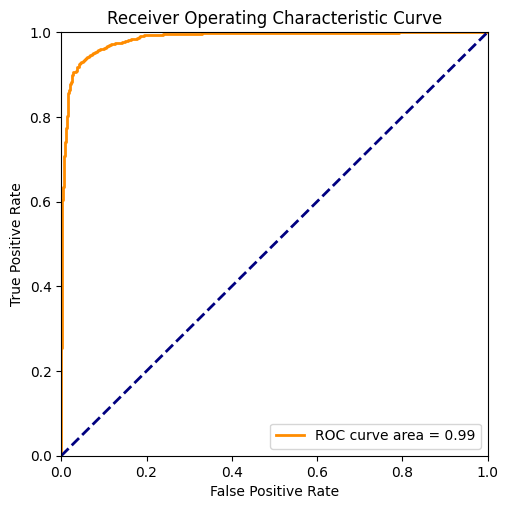

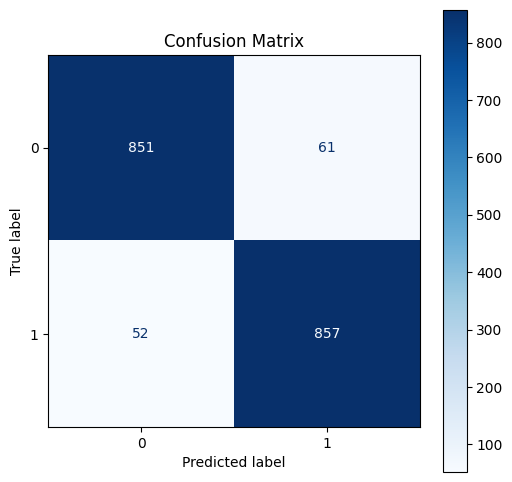



	Model saved to /content/drive/My Drive/binary_sentiment_classification/models/roberta-base/model.pt
	Metrics saved to /content/drive/My Drive/binary_sentiment_classification/models/roberta-base/metrics.tsv
	ROC curve saved to /content/drive/My Drive/binary_sentiment_classification/models/roberta-base/roc_curve.png
	Confusion matrix saved to /content/drive/My Drive/binary_sentiment_classification/models/roberta-base/confusion_matrix.png


EPOCH 2:

	TRAINING:


		Average batch time - 0.2746s		Running loss - 0.1889		: 100%|██████████| 217/217 [01:02<00:00,  3.45it/s]


		Time      : 62.9131s
		Loss      : 0.1889
		Accuracy  : 93.2803%

	VALIDATION:
		Time      : 2.4628s
		Loss      : 0.2857
		Accuracy  : 90.0229%
		ROC-AUC   : 0.9736

	EARLY STOPPING:
		Validation accuracy not improving...




config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(




BEGIN FINETUNING PROCESS

	INFO:
		Model     - ROBERTA-LARGE
		Device    - CUDA

	INITIAL VALIDATION:
		Time      : 8.5852s
		Loss      : 0.7148
		Accuracy  : 49.0826%
		AUC       : 0.4835


EPOCH 1:

	TRAINING:


		Average batch time - 0.9905s		Running loss - 0.5813		: 100%|██████████| 217/217 [03:36<00:00,  1.00it/s]


		Time      : 216.3688s
		Loss      : 0.5813
		Accuracy  : 67.3555%

	VALIDATION:
		Time      : 9.2997s
		Loss      : 0.3428
		Accuracy  : 91.2844%
		ROC-AUC   : 0.9430

	TESTING:
		Time      : 19.3788s
		Loss      : 0.3373
		Accuracy  : 90.3350%
		Precision : 87.5128%
		Recall    : 94.0594%
		F1        : 0.9067
		ROC-AUC   : 0.9482




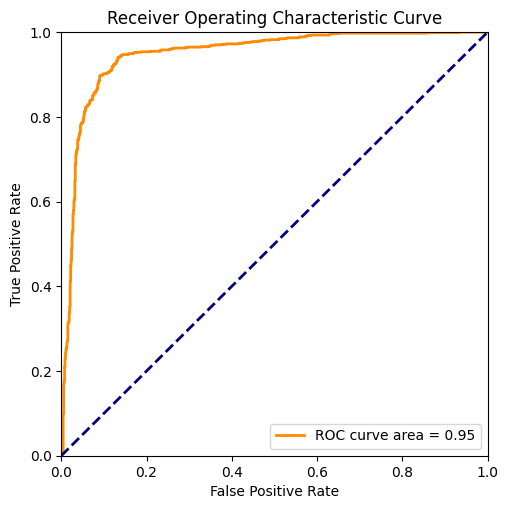

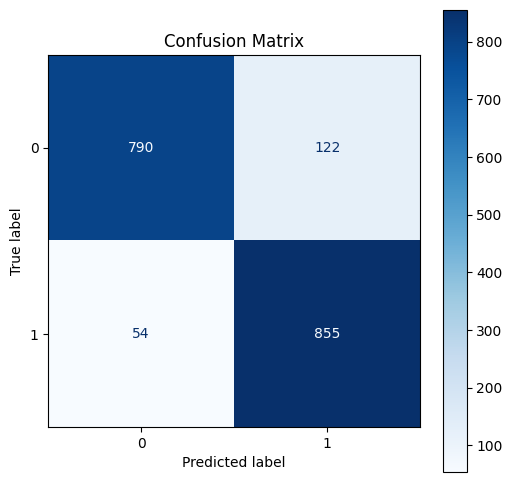



	Model saved to /content/drive/My Drive/binary_sentiment_classification/models/roberta-large/model.pt
	Metrics saved to /content/drive/My Drive/binary_sentiment_classification/models/roberta-large/metrics.tsv
	ROC curve saved to /content/drive/My Drive/binary_sentiment_classification/models/roberta-large/roc_curve.png
	Confusion matrix saved to /content/drive/My Drive/binary_sentiment_classification/models/roberta-large/confusion_matrix.png


EPOCH 2:

	TRAINING:


		Average batch time - 0.9904s		Running loss - 0.2592		: 100%|██████████| 217/217 [03:36<00:00,  1.00it/s]


		Time      : 216.3569s
		Loss      : 0.2592
		Accuracy  : 91.6763%

	VALIDATION:
		Time      : 9.2453s
		Loss      : 0.3206
		Accuracy  : 89.9083%
		ROC-AUC   : 0.9215

	EARLY STOPPING:
		Validation accuracy not improving...




config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(




BEGIN FINETUNING PROCESS

	INFO:
		Model     - DISTILROBERTA-BASE
		Device    - CUDA

	INITIAL VALIDATION:
		Time      : 1.2547s
		Loss      : 0.6959
		Accuracy  : 49.0826%
		AUC       : 0.3892


EPOCH 1:

	TRAINING:


		Average batch time - 0.0615s		Running loss - 0.4073		: 100%|██████████| 217/217 [00:32<00:00,  6.62it/s]


		Time      : 32.7662s
		Loss      : 0.4073
		Accuracy  : 79.4364%

	VALIDATION:
		Time      : 1.2642s
		Loss      : 0.2593
		Accuracy  : 89.3349%
		ROC-AUC   : 0.9612

	TESTING:
		Time      : 2.6258s
		Loss      : 0.2081
		Accuracy  : 91.5980%
		Precision : 93.2494%
		Recall    : 89.6590%
		F1        : 0.9142
		ROC-AUC   : 0.9747




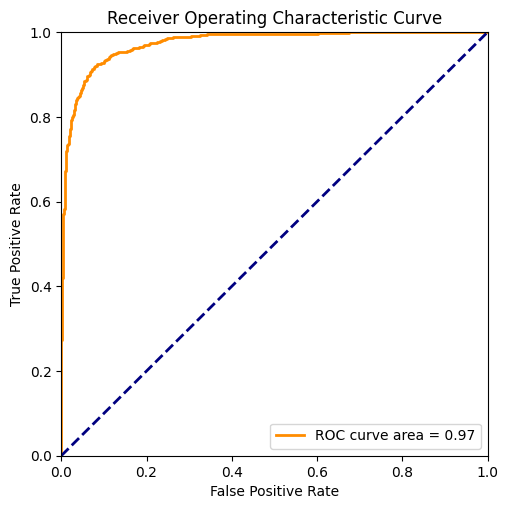

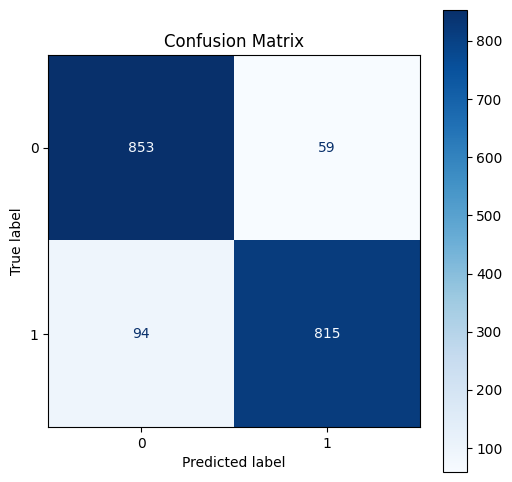



	Model saved to /content/drive/My Drive/binary_sentiment_classification/models/distilroberta-base/model.pt
	Metrics saved to /content/drive/My Drive/binary_sentiment_classification/models/distilroberta-base/metrics.tsv
	ROC curve saved to /content/drive/My Drive/binary_sentiment_classification/models/distilroberta-base/roc_curve.png
	Confusion matrix saved to /content/drive/My Drive/binary_sentiment_classification/models/distilroberta-base/confusion_matrix.png


EPOCH 2:

	TRAINING:


		Average batch time - 0.0607s		Running loss - 0.2099		: 100%|██████████| 217/217 [00:32<00:00,  6.64it/s]


		Time      : 32.6871s
		Loss      : 0.2099
		Accuracy  : 91.9220%

	VALIDATION:
		Time      : 1.2387s
		Loss      : 0.3462
		Accuracy  : 88.8761%
		ROC-AUC   : 0.9662

	EARLY STOPPING:
		Validation accuracy not improving...




config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(




BEGIN FINETUNING PROCESS

	INFO:
		Model     - CAMEMBERT-BASE
		Device    - CUDA

	INITIAL VALIDATION:
		Time      : 2.3611s
		Loss      : 0.6935
		Accuracy  : 51.1468%
		AUC       : 0.4775


EPOCH 1:

	TRAINING:


		Average batch time - 0.2748s		Running loss - 0.6200		: 100%|██████████| 217/217 [01:02<00:00,  3.45it/s]


		Time      : 62.9256s
		Loss      : 0.6200
		Accuracy  : 64.7688%

	VALIDATION:
		Time      : 2.4664s
		Loss      : 0.4443
		Accuracy  : 81.0780%
		ROC-AUC   : 0.8939

	TESTING:
		Time      : 5.1686s
		Loss      : 0.4491
		Accuracy  : 80.7249%
		Precision : 83.5337%
		Recall    : 76.4576%
		F1        : 0.7984
		ROC-AUC   : 0.8752




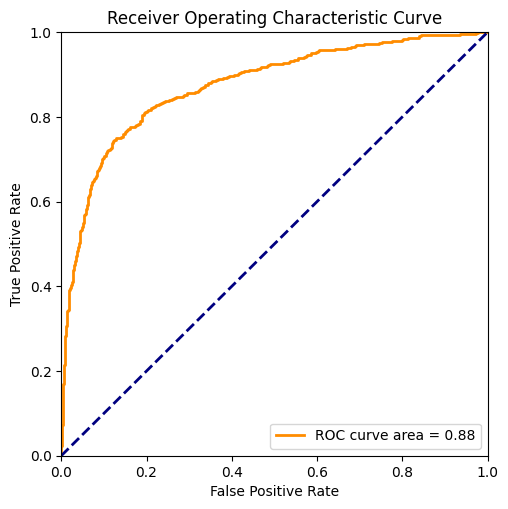

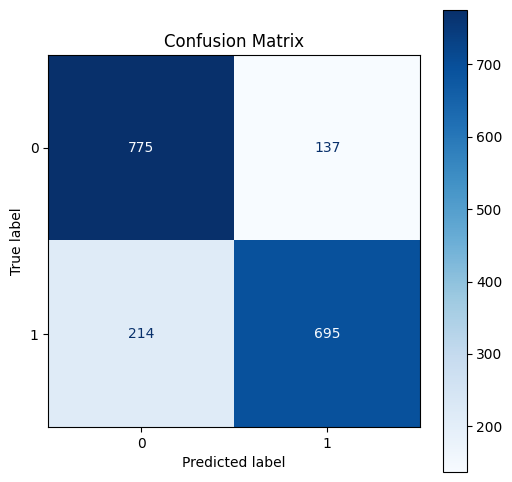



	Model saved to /content/drive/My Drive/binary_sentiment_classification/models/camembert-base/model.pt
	Metrics saved to /content/drive/My Drive/binary_sentiment_classification/models/camembert-base/metrics.tsv
	ROC curve saved to /content/drive/My Drive/binary_sentiment_classification/models/camembert-base/roc_curve.png
	Confusion matrix saved to /content/drive/My Drive/binary_sentiment_classification/models/camembert-base/confusion_matrix.png


EPOCH 2:

	TRAINING:


		Average batch time - 0.2745s		Running loss - 0.4530		: 100%|██████████| 217/217 [01:02<00:00,  3.45it/s]


		Time      : 62.8487s
		Loss      : 0.4530
		Accuracy  : 79.4942%

	VALIDATION:
		Time      : 2.4754s
		Loss      : 0.3932
		Accuracy  : 83.6009%
		ROC-AUC   : 0.9203

	TESTING:
		Time      : 5.1727s
		Loss      : 0.4075
		Accuracy  : 82.8666%
		Precision : 78.9525%
		Recall    : 89.5490%
		F1        : 0.8392
		ROC-AUC   : 0.9129




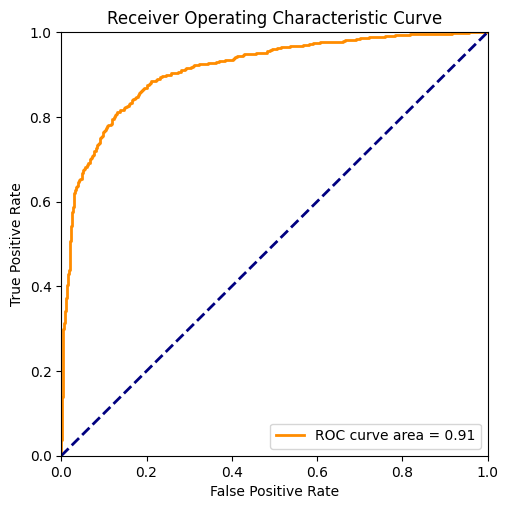

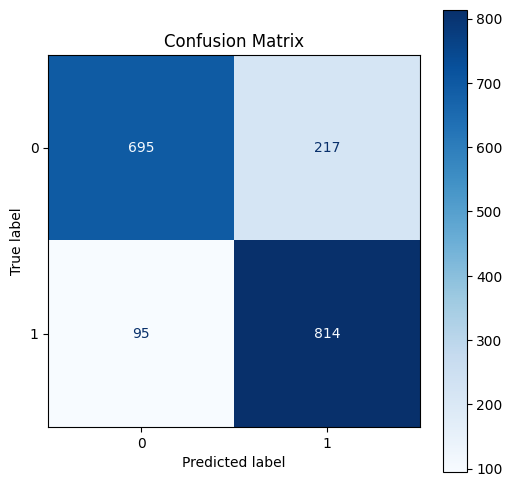



	Model saved to /content/drive/My Drive/binary_sentiment_classification/models/camembert-base/model.pt
	Metrics saved to /content/drive/My Drive/binary_sentiment_classification/models/camembert-base/metrics.tsv
	ROC curve saved to /content/drive/My Drive/binary_sentiment_classification/models/camembert-base/roc_curve.png
	Confusion matrix saved to /content/drive/My Drive/binary_sentiment_classification/models/camembert-base/confusion_matrix.png


EPOCH 3:

	TRAINING:


		Average batch time - 0.2746s		Running loss - 0.3201		: 100%|██████████| 217/217 [01:02<00:00,  3.45it/s]


		Time      : 62.9300s
		Loss      : 0.3201
		Accuracy  : 87.0087%

	VALIDATION:
		Time      : 2.4927s
		Loss      : 0.4781
		Accuracy  : 82.2248%
		ROC-AUC   : 0.9248

	EARLY STOPPING:
		Validation accuracy not improving...




config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(




BEGIN FINETUNING PROCESS

	INFO:
		Model     - XLM-ROBERTA-BASE
		Device    - CUDA

	INITIAL VALIDATION:
		Time      : 2.3340s
		Loss      : 0.7039
		Accuracy  : 50.9174%
		AUC       : 0.5349


EPOCH 1:

	TRAINING:


		Average batch time - 0.3478s		Running loss - 0.4726		: 100%|██████████| 217/217 [01:18<00:00,  2.76it/s]


		Time      : 78.5961s
		Loss      : 0.4726
		Accuracy  : 77.3555%

	VALIDATION:
		Time      : 2.4697s
		Loss      : 0.3485
		Accuracy  : 86.8119%
		ROC-AUC   : 0.9458

	TESTING:
		Time      : 5.1705s
		Loss      : 0.3053
		Accuracy  : 88.5228%
		Precision : 96.4191%
		Recall    : 79.9780%
		F1        : 0.8743
		ROC-AUC   : 0.9523




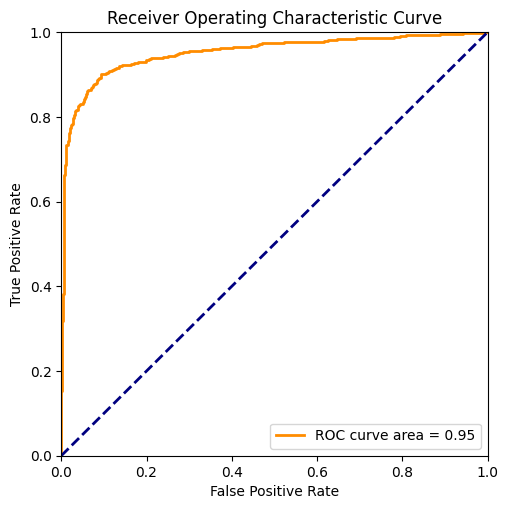

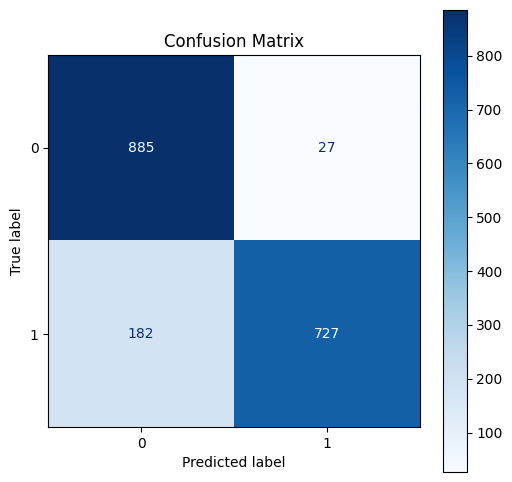



	Model saved to /content/drive/My Drive/binary_sentiment_classification/models/xlm-roberta-base/model.pt
	Metrics saved to /content/drive/My Drive/binary_sentiment_classification/models/xlm-roberta-base/metrics.tsv
	ROC curve saved to /content/drive/My Drive/binary_sentiment_classification/models/xlm-roberta-base/roc_curve.png
	Confusion matrix saved to /content/drive/My Drive/binary_sentiment_classification/models/xlm-roberta-base/confusion_matrix.png


EPOCH 2:

	TRAINING:


		Average batch time - 0.3469s		Running loss - 0.2586		: 100%|██████████| 217/217 [01:18<00:00,  2.76it/s]


		Time      : 78.5116s
		Loss      : 0.2586
		Accuracy  : 90.1301%

	VALIDATION:
		Time      : 2.4750s
		Loss      : 0.3339
		Accuracy  : 87.0413%
		ROC-AUC   : 0.9527

	TESTING:
		Time      : 5.1610s
		Loss      : 0.2755
		Accuracy  : 89.4014%
		Precision : 86.3821%
		Recall    : 93.5094%
		F1        : 0.8980
		ROC-AUC   : 0.9673




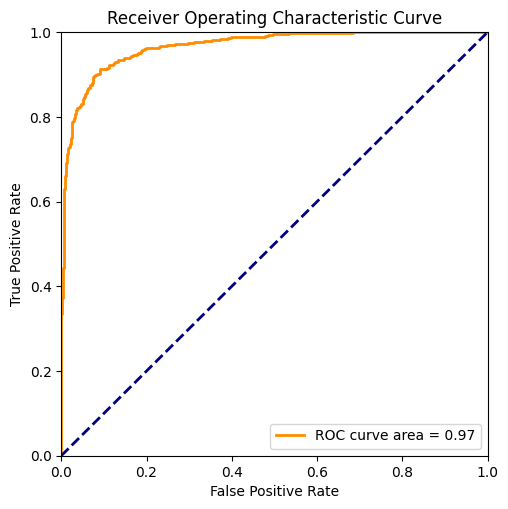

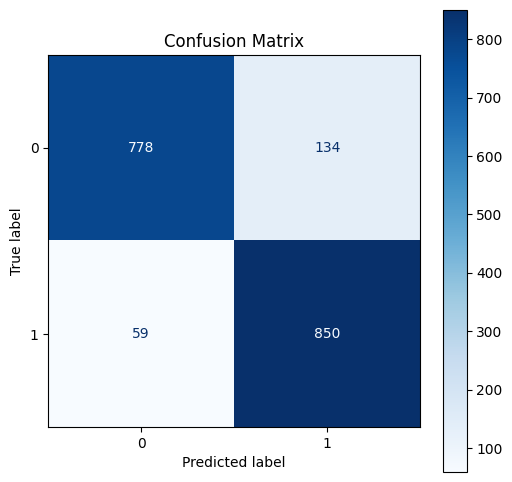



	Model saved to /content/drive/My Drive/binary_sentiment_classification/models/xlm-roberta-base/model.pt
	Metrics saved to /content/drive/My Drive/binary_sentiment_classification/models/xlm-roberta-base/metrics.tsv
	ROC curve saved to /content/drive/My Drive/binary_sentiment_classification/models/xlm-roberta-base/roc_curve.png
	Confusion matrix saved to /content/drive/My Drive/binary_sentiment_classification/models/xlm-roberta-base/confusion_matrix.png


EPOCH 3:

	TRAINING:


		Average batch time - 0.3470s		Running loss - 0.1553		: 100%|██████████| 217/217 [01:18<00:00,  2.76it/s]


		Time      : 78.5303s
		Loss      : 0.1553
		Accuracy  : 94.4509%

	VALIDATION:
		Time      : 2.4660s
		Loss      : 0.3481
		Accuracy  : 89.2202%
		ROC-AUC   : 0.9615

	TESTING:
		Time      : 5.1411s
		Loss      : 0.3073
		Accuracy  : 89.5662%
		Precision : 86.0582%
		Recall    : 94.3894%
		F1        : 0.9003
		ROC-AUC   : 0.9686




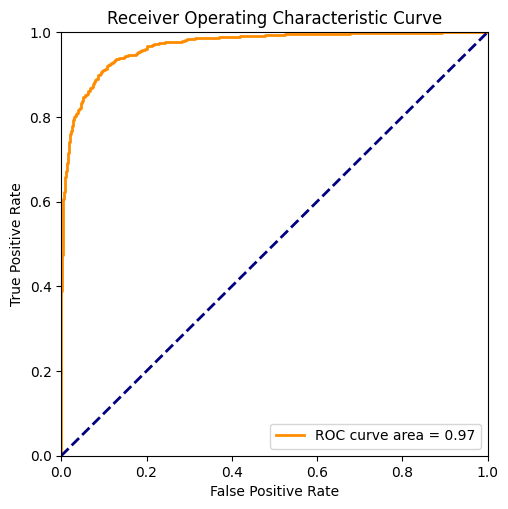

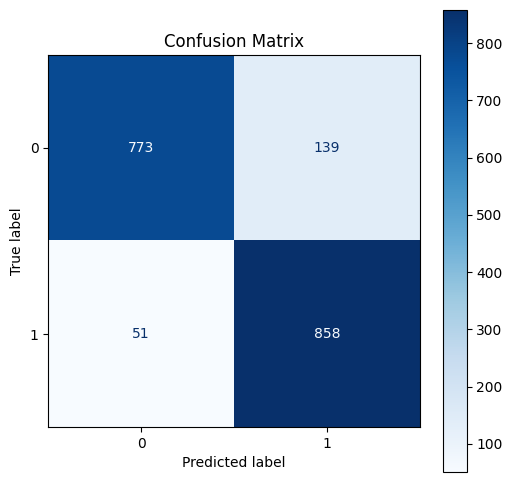



	Model saved to /content/drive/My Drive/binary_sentiment_classification/models/xlm-roberta-base/model.pt
	Metrics saved to /content/drive/My Drive/binary_sentiment_classification/models/xlm-roberta-base/metrics.tsv
	ROC curve saved to /content/drive/My Drive/binary_sentiment_classification/models/xlm-roberta-base/roc_curve.png
	Confusion matrix saved to /content/drive/My Drive/binary_sentiment_classification/models/xlm-roberta-base/confusion_matrix.png


EPOCH 4:

	TRAINING:


		Average batch time - 0.3463s		Running loss - 0.1086		: 100%|██████████| 217/217 [01:18<00:00,  2.77it/s]


		Time      : 78.4075s
		Loss      : 0.1086
		Accuracy  : 96.7341%

	VALIDATION:
		Time      : 2.4816s
		Loss      : 0.3515
		Accuracy  : 90.1376%
		ROC-AUC   : 0.9570

	TESTING:
		Time      : 5.1723s
		Loss      : 0.3082
		Accuracy  : 91.0489%
		Precision : 88.7734%
		Recall    : 93.9494%
		F1        : 0.9129
		ROC-AUC   : 0.9657




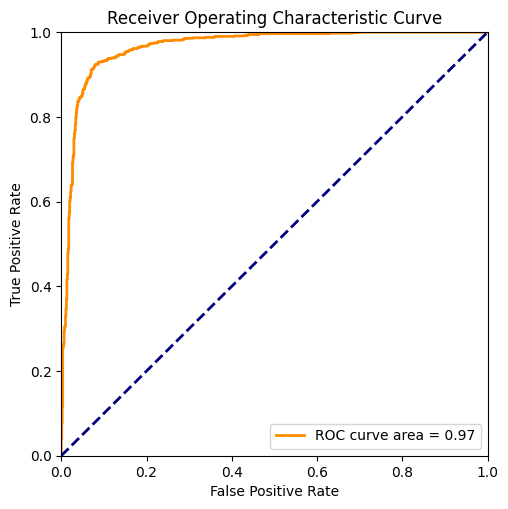

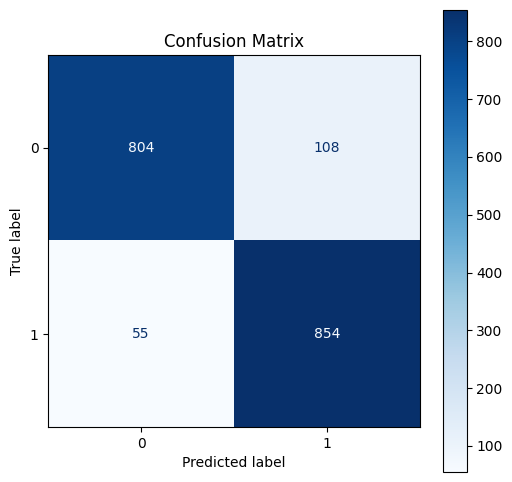



	Model saved to /content/drive/My Drive/binary_sentiment_classification/models/xlm-roberta-base/model.pt
	Metrics saved to /content/drive/My Drive/binary_sentiment_classification/models/xlm-roberta-base/metrics.tsv
	ROC curve saved to /content/drive/My Drive/binary_sentiment_classification/models/xlm-roberta-base/roc_curve.png
	Confusion matrix saved to /content/drive/My Drive/binary_sentiment_classification/models/xlm-roberta-base/confusion_matrix.png


EPOCH 5:

	TRAINING:


		Average batch time - 0.3463s		Running loss - 0.0764		: 100%|██████████| 217/217 [01:18<00:00,  2.77it/s]


		Time      : 78.4578s
		Loss      : 0.0764
		Accuracy  : 97.3699%

	VALIDATION:
		Time      : 2.4832s
		Loss      : 0.5194
		Accuracy  : 87.3853%
		ROC-AUC   : 0.9515

	EARLY STOPPING:
		Validation accuracy not improving...




config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(




BEGIN FINETUNING PROCESS

	INFO:
		Model     - XLM-ROBERTA-LARGE
		Device    - CUDA

	INITIAL VALIDATION:
		Time      : 8.7372s
		Loss      : 0.6975
		Accuracy  : 45.6422%
		AUC       : 0.4471


EPOCH 1:

	TRAINING:


		Average batch time - 1.1019s		Running loss - 0.4400		: 100%|██████████| 217/217 [04:00<00:00,  1.11s/it]


		Time      : 240.5451s
		Loss      : 0.4400
		Accuracy  : 79.4798%

	VALIDATION:
		Time      : 9.4815s
		Loss      : 0.3796
		Accuracy  : 87.8440%
		ROC-AUC   : 0.9671

	TESTING:
		Time      : 19.6786s
		Loss      : 0.3530
		Accuracy  : 88.3580%
		Precision : 81.8265%
		Recall    : 98.5699%
		F1        : 0.8942
		ROC-AUC   : 0.9784




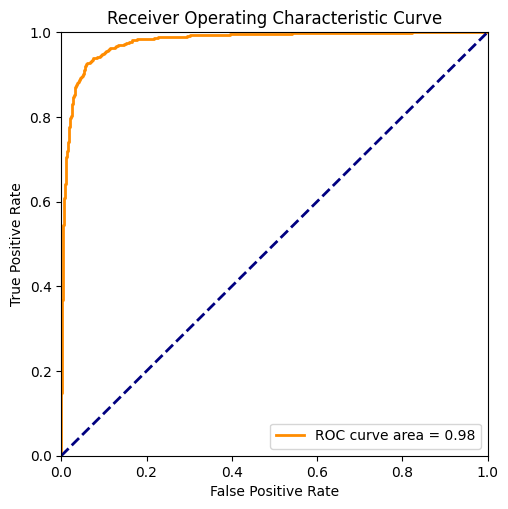

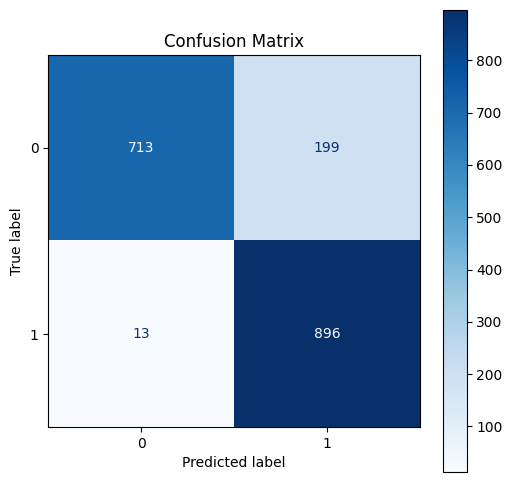



	Model saved to /content/drive/My Drive/binary_sentiment_classification/models/xlm-roberta-large/model.pt
	Metrics saved to /content/drive/My Drive/binary_sentiment_classification/models/xlm-roberta-large/metrics.tsv
	ROC curve saved to /content/drive/My Drive/binary_sentiment_classification/models/xlm-roberta-large/roc_curve.png
	Confusion matrix saved to /content/drive/My Drive/binary_sentiment_classification/models/xlm-roberta-large/confusion_matrix.png


EPOCH 2:

	TRAINING:


		Average batch time - 1.1010s		Running loss - 0.2211		: 100%|██████████| 217/217 [04:00<00:00,  1.11s/it]


		Time      : 240.4168s
		Loss      : 0.2211
		Accuracy  : 91.9509%

	VALIDATION:
		Time      : 9.4529s
		Loss      : 0.2143
		Accuracy  : 92.3165%
		ROC-AUC   : 0.9732

	TESTING:
		Time      : 19.7169s
		Loss      : 0.1855
		Accuracy  : 93.0807%
		Precision : 91.4286%
		Recall    : 95.0495%
		F1        : 0.9320
		ROC-AUC   : 0.9817




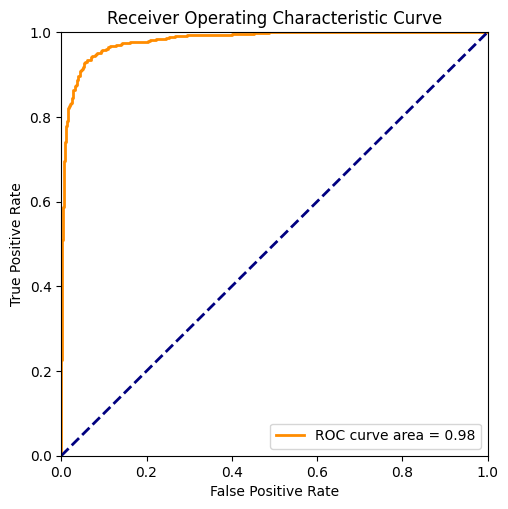

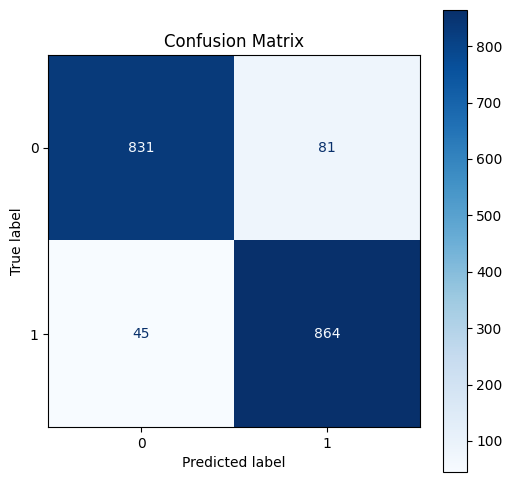



	Model saved to /content/drive/My Drive/binary_sentiment_classification/models/xlm-roberta-large/model.pt
	Metrics saved to /content/drive/My Drive/binary_sentiment_classification/models/xlm-roberta-large/metrics.tsv
	ROC curve saved to /content/drive/My Drive/binary_sentiment_classification/models/xlm-roberta-large/roc_curve.png
	Confusion matrix saved to /content/drive/My Drive/binary_sentiment_classification/models/xlm-roberta-large/confusion_matrix.png


EPOCH 3:

	TRAINING:


		Average batch time - 1.1011s		Running loss - 0.1388		: 100%|██████████| 217/217 [04:00<00:00,  1.11s/it]


		Time      : 240.4259s
		Loss      : 0.1388
		Accuracy  : 95.6503%

	VALIDATION:
		Time      : 9.4160s
		Loss      : 0.2819
		Accuracy  : 91.1697%
		ROC-AUC   : 0.9705

	EARLY STOPPING:
		Validation accuracy not improving...




config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(




BEGIN FINETUNING PROCESS

	INFO:
		Model     - XLNET-BASE-CASED
		Device    - CUDA

	INITIAL VALIDATION:
		Time      : 3.2815s
		Loss      : 0.7409
		Accuracy  : 49.1972%
		AUC       : 0.5211


EPOCH 1:

	TRAINING:


		Average batch time - 0.3293s		Running loss - 0.3454		: 100%|██████████| 217/217 [01:15<00:00,  2.87it/s]


		Time      : 75.7083s
		Loss      : 0.3454
		Accuracy  : 84.7688%

	VALIDATION:
		Time      : 3.0865s
		Loss      : 0.2438
		Accuracy  : 91.3991%
		ROC-AUC   : 0.9769

	TESTING:
		Time      : 6.4331s
		Loss      : 0.2548
		Accuracy  : 90.2801%
		Precision : 85.1248%
		Recall    : 97.5798%
		F1        : 0.9093
		ROC-AUC   : 0.9792




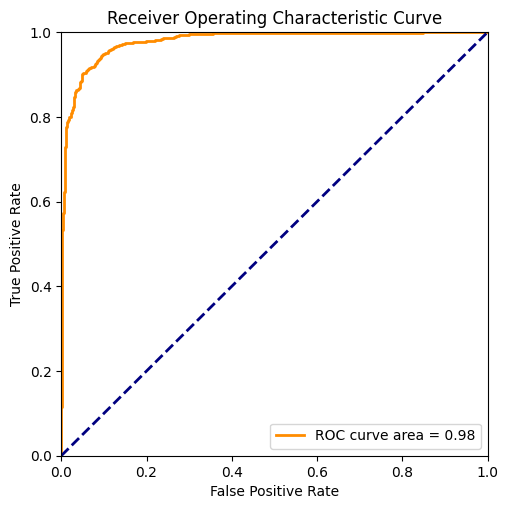

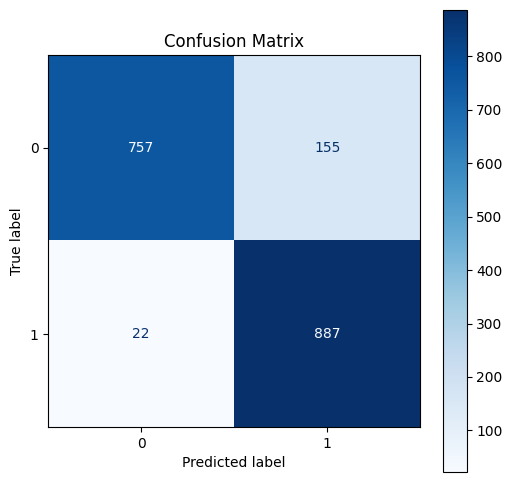



	Model saved to /content/drive/My Drive/binary_sentiment_classification/models/xlnet-base-cased/model.pt
	Metrics saved to /content/drive/My Drive/binary_sentiment_classification/models/xlnet-base-cased/metrics.tsv
	ROC curve saved to /content/drive/My Drive/binary_sentiment_classification/models/xlnet-base-cased/roc_curve.png
	Confusion matrix saved to /content/drive/My Drive/binary_sentiment_classification/models/xlnet-base-cased/confusion_matrix.png


EPOCH 2:

	TRAINING:


		Average batch time - 0.3288s		Running loss - 0.1838		: 100%|██████████| 217/217 [01:15<00:00,  2.87it/s]


		Time      : 75.6586s
		Loss      : 0.1838
		Accuracy  : 93.1069%

	VALIDATION:
		Time      : 3.1104s
		Loss      : 0.2530
		Accuracy  : 91.6284%
		ROC-AUC   : 0.9758

	TESTING:
		Time      : 6.4666s
		Loss      : 0.2403
		Accuracy  : 90.9940%
		Precision : 86.9911%
		Recall    : 96.3696%
		F1        : 0.9144
		ROC-AUC   : 0.9820




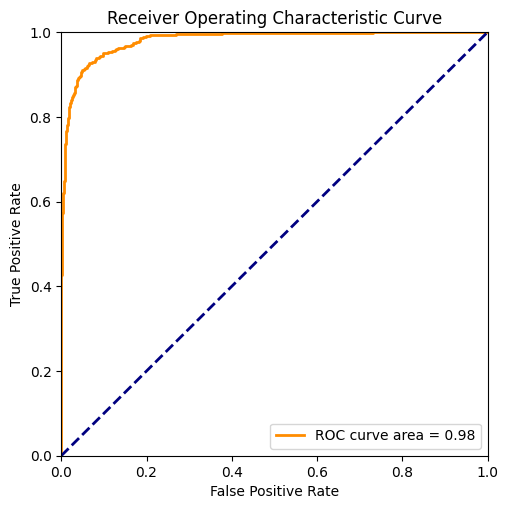

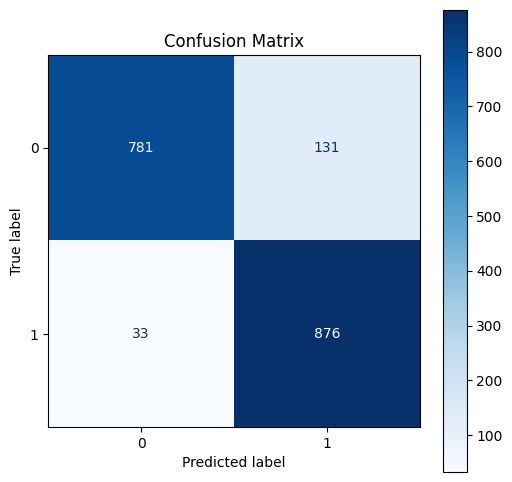



	Model saved to /content/drive/My Drive/binary_sentiment_classification/models/xlnet-base-cased/model.pt
	Metrics saved to /content/drive/My Drive/binary_sentiment_classification/models/xlnet-base-cased/metrics.tsv
	ROC curve saved to /content/drive/My Drive/binary_sentiment_classification/models/xlnet-base-cased/roc_curve.png
	Confusion matrix saved to /content/drive/My Drive/binary_sentiment_classification/models/xlnet-base-cased/confusion_matrix.png


EPOCH 3:

	TRAINING:


		Average batch time - 0.3284s		Running loss - 0.1095		: 100%|██████████| 217/217 [01:15<00:00,  2.87it/s]


		Time      : 75.6412s
		Loss      : 0.1095
		Accuracy  : 96.2861%

	VALIDATION:
		Time      : 3.1231s
		Loss      : 0.2832
		Accuracy  : 92.7752%
		ROC-AUC   : 0.9781

	TESTING:
		Time      : 6.4683s
		Loss      : 0.2417
		Accuracy  : 91.5431%
		Precision : 87.7123%
		Recall    : 96.5897%
		F1        : 0.9194
		ROC-AUC   : 0.9829




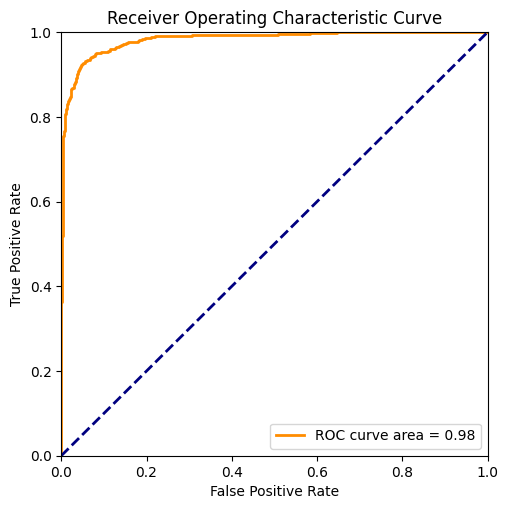

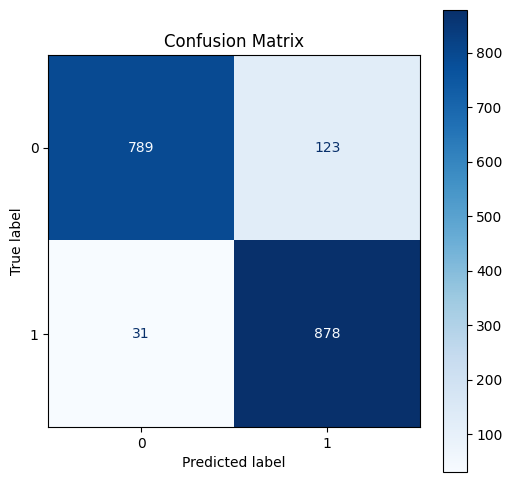



	Model saved to /content/drive/My Drive/binary_sentiment_classification/models/xlnet-base-cased/model.pt
	Metrics saved to /content/drive/My Drive/binary_sentiment_classification/models/xlnet-base-cased/metrics.tsv
	ROC curve saved to /content/drive/My Drive/binary_sentiment_classification/models/xlnet-base-cased/roc_curve.png
	Confusion matrix saved to /content/drive/My Drive/binary_sentiment_classification/models/xlnet-base-cased/confusion_matrix.png


EPOCH 4:

	TRAINING:


		Average batch time - 0.3296s		Running loss - 0.0609		: 100%|██████████| 217/217 [01:15<00:00,  2.86it/s]


		Time      : 75.9827s
		Loss      : 0.0609
		Accuracy  : 97.8613%

	VALIDATION:
		Time      : 3.0953s
		Loss      : 0.3258
		Accuracy  : 92.5459%
		ROC-AUC   : 0.9758

	EARLY STOPPING:
		Validation accuracy not improving...




config.json:   0%|          | 0.00/761 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.44G [00:00<?, ?B/s]

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-large-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(




BEGIN FINETUNING PROCESS

	INFO:
		Model     - XLNET-LARGE-CASED
		Device    - CUDA

	INITIAL VALIDATION:
		Time      : 10.9168s
		Loss      : 0.7793
		Accuracy  : 50.4587%
		AUC       : 0.5350


EPOCH 1:

	TRAINING:


		Average batch time - 1.1965s		Running loss - 0.4320		: 100%|██████████| 217/217 [04:21<00:00,  1.20s/it]


		Time      : 261.1891s
		Loss      : 0.4320
		Accuracy  : 78.2803%

	VALIDATION:
		Time      : 11.1979s
		Loss      : 0.2279
		Accuracy  : 92.4312%
		ROC-AUC   : 0.9786

	TESTING:
		Time      : 23.3084s
		Loss      : 0.1983
		Accuracy  : 92.9160%
		Precision : 96.9880%
		Recall    : 88.5589%
		F1        : 0.9258
		ROC-AUC   : 0.9798




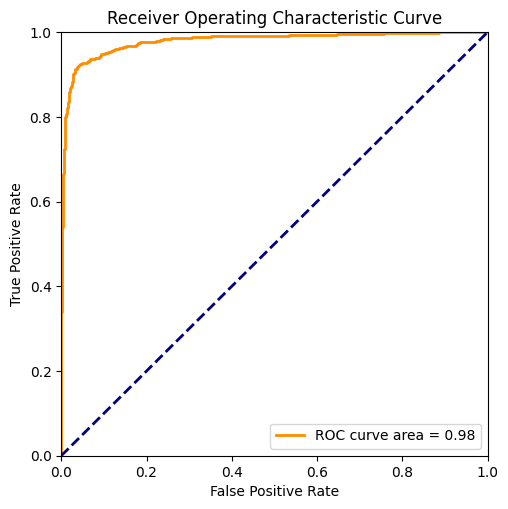

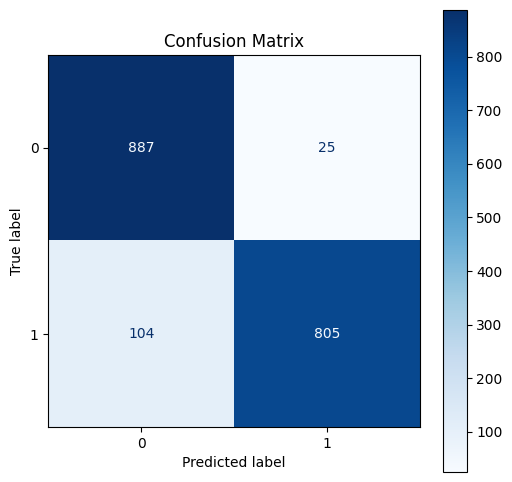



	Model saved to /content/drive/My Drive/binary_sentiment_classification/models/xlnet-large-cased/model.pt
	Metrics saved to /content/drive/My Drive/binary_sentiment_classification/models/xlnet-large-cased/metrics.tsv
	ROC curve saved to /content/drive/My Drive/binary_sentiment_classification/models/xlnet-large-cased/roc_curve.png
	Confusion matrix saved to /content/drive/My Drive/binary_sentiment_classification/models/xlnet-large-cased/confusion_matrix.png


EPOCH 2:

	TRAINING:


		Average batch time - 1.1950s		Running loss - 0.1894		: 100%|██████████| 217/217 [04:20<00:00,  1.20s/it]


		Time      : 260.9608s
		Loss      : 0.1894
		Accuracy  : 93.4538%

	VALIDATION:
		Time      : 11.1861s
		Loss      : 0.1887
		Accuracy  : 94.4954%
		ROC-AUC   : 0.9814

	TESTING:
		Time      : 23.3531s
		Loss      : 0.1654
		Accuracy  : 94.6733%
		Precision : 94.4201%
		Recall    : 94.9395%
		F1        : 0.9468
		ROC-AUC   : 0.9885




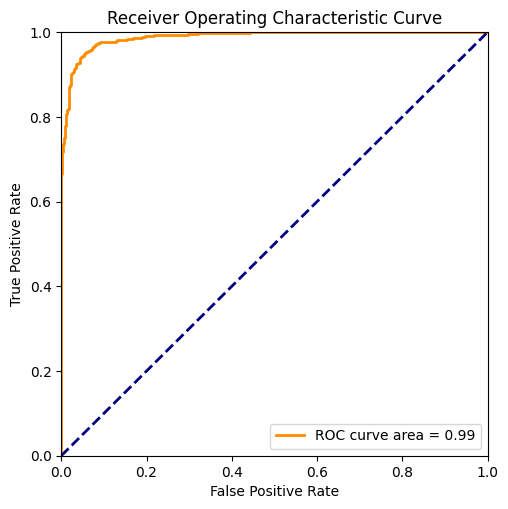

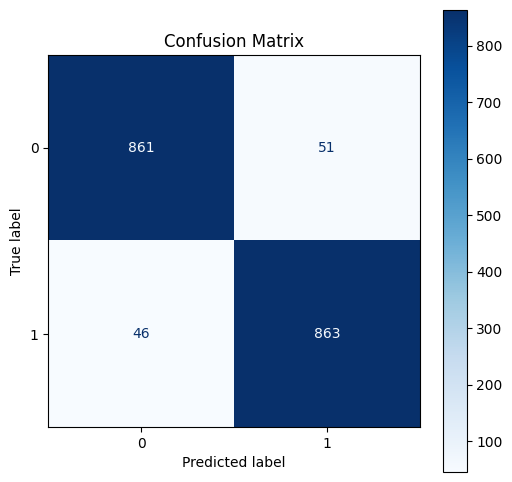



	Model saved to /content/drive/My Drive/binary_sentiment_classification/models/xlnet-large-cased/model.pt
	Metrics saved to /content/drive/My Drive/binary_sentiment_classification/models/xlnet-large-cased/metrics.tsv
	ROC curve saved to /content/drive/My Drive/binary_sentiment_classification/models/xlnet-large-cased/roc_curve.png
	Confusion matrix saved to /content/drive/My Drive/binary_sentiment_classification/models/xlnet-large-cased/confusion_matrix.png


EPOCH 3:

	TRAINING:


		Average batch time - 1.1960s		Running loss - 0.1097		: 100%|██████████| 217/217 [04:21<00:00,  1.20s/it]


		Time      : 261.1811s
		Loss      : 0.1097
		Accuracy  : 96.4451%

	VALIDATION:
		Time      : 11.1440s
		Loss      : 0.2010
		Accuracy  : 94.7248%
		ROC-AUC   : 0.9843

	TESTING:
		Time      : 23.2928s
		Loss      : 0.1914
		Accuracy  : 94.5634%
		Precision : 92.5420%
		Recall    : 96.9197%
		F1        : 0.9468
		ROC-AUC   : 0.9872




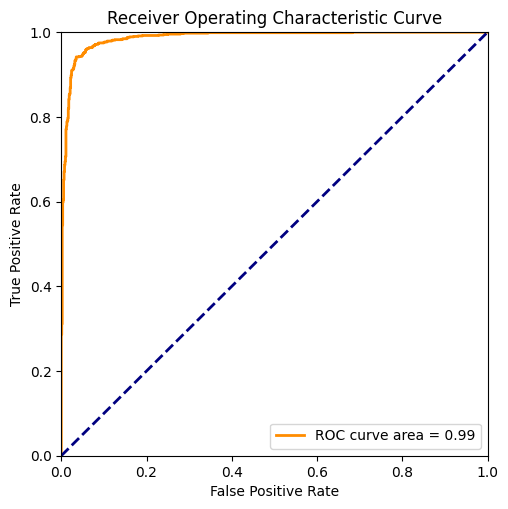

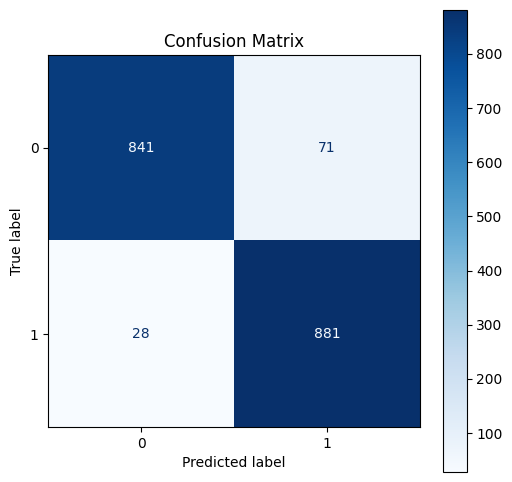



	Model saved to /content/drive/My Drive/binary_sentiment_classification/models/xlnet-large-cased/model.pt
	Metrics saved to /content/drive/My Drive/binary_sentiment_classification/models/xlnet-large-cased/metrics.tsv
	ROC curve saved to /content/drive/My Drive/binary_sentiment_classification/models/xlnet-large-cased/roc_curve.png
	Confusion matrix saved to /content/drive/My Drive/binary_sentiment_classification/models/xlnet-large-cased/confusion_matrix.png


EPOCH 4:

	TRAINING:


		Average batch time - 1.1947s		Running loss - 0.0690		: 100%|██████████| 217/217 [04:20<00:00,  1.20s/it]


		Time      : 260.9531s
		Loss      : 0.0690
		Accuracy  : 97.8902%

	VALIDATION:
		Time      : 11.1164s
		Loss      : 0.1992
		Accuracy  : 94.7248%
		ROC-AUC   : 0.9858

	TESTING:
		Time      : 23.2337s
		Loss      : 0.1678
		Accuracy  : 94.7831%
		Precision : 94.6272%
		Recall    : 94.9395%
		F1        : 0.9478
		ROC-AUC   : 0.9902




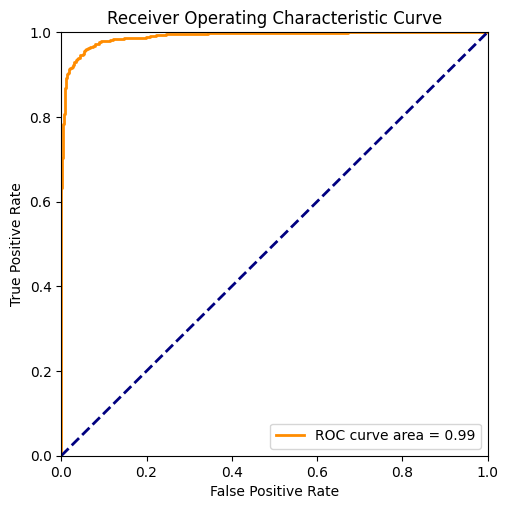

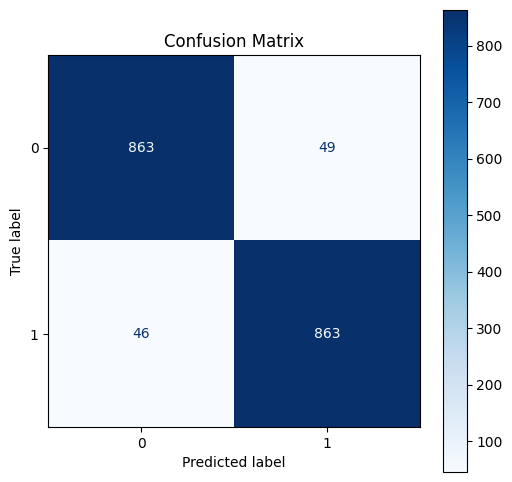



	Model saved to /content/drive/My Drive/binary_sentiment_classification/models/xlnet-large-cased/model.pt
	Metrics saved to /content/drive/My Drive/binary_sentiment_classification/models/xlnet-large-cased/metrics.tsv
	ROC curve saved to /content/drive/My Drive/binary_sentiment_classification/models/xlnet-large-cased/roc_curve.png
	Confusion matrix saved to /content/drive/My Drive/binary_sentiment_classification/models/xlnet-large-cased/confusion_matrix.png


EPOCH 5:

	TRAINING:


		Average batch time - 1.1931s		Running loss - 0.0367		: 100%|██████████| 217/217 [04:20<00:00,  1.20s/it]


		Time      : 260.5323s
		Loss      : 0.0367
		Accuracy  : 98.8295%

	VALIDATION:
		Time      : 11.1355s
		Loss      : 0.1980
		Accuracy  : 94.7248%
		ROC-AUC   : 0.9820

	TESTING:
		Time      : 23.1570s
		Loss      : 0.1894
		Accuracy  : 94.8380%
		Precision : 95.2275%
		Recall    : 94.3894%
		F1        : 0.9481
		ROC-AUC   : 0.9879




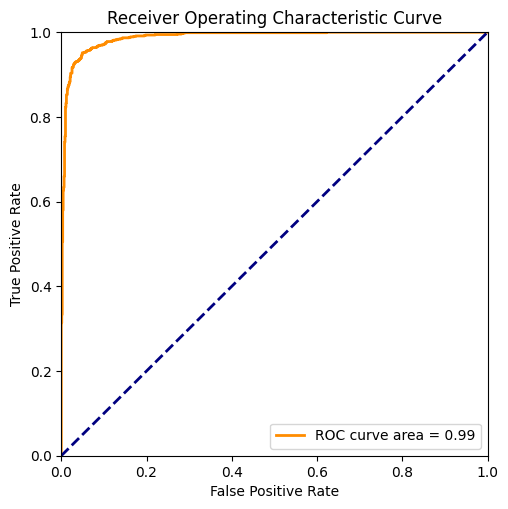

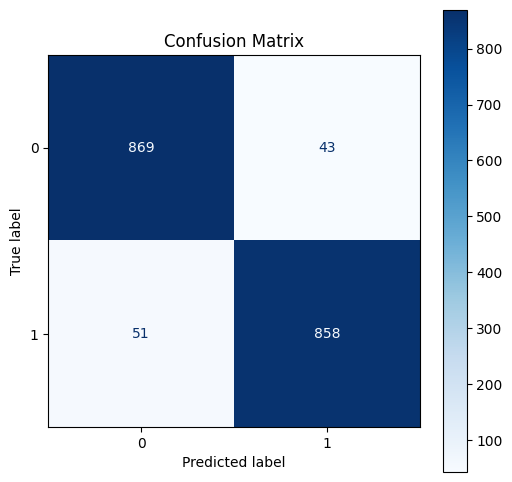



	Model saved to /content/drive/My Drive/binary_sentiment_classification/models/xlnet-large-cased/model.pt
	Metrics saved to /content/drive/My Drive/binary_sentiment_classification/models/xlnet-large-cased/metrics.tsv
	ROC curve saved to /content/drive/My Drive/binary_sentiment_classification/models/xlnet-large-cased/roc_curve.png
	Confusion matrix saved to /content/drive/My Drive/binary_sentiment_classification/models/xlnet-large-cased/confusion_matrix.png


EPOCH 6:

	TRAINING:


		Average batch time - 1.1947s		Running loss - 0.0282		: 100%|██████████| 217/217 [04:20<00:00,  1.20s/it]


		Time      : 260.8316s
		Loss      : 0.0282
		Accuracy  : 99.3353%

	VALIDATION:
		Time      : 11.1584s
		Loss      : 0.2870
		Accuracy  : 94.0367%
		ROC-AUC   : 0.9852

	EARLY STOPPING:
		Validation accuracy not improving...




In [ ]:
for model_name in PRETRAINED_MODELS.keys():
  finetune_model(
        train_dataframe,
        validation_dataframe,
        test_dataframe,

        model_name=model_name,

        max_sequence_length=50,
        epochs=10,
        batch_size=32,
        lr=2e-05,
        patience=1,
        max_grad_norm=10.0
  )